<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/pulsar_pca_xgb_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 14th June, 2023

## Basics

In [1]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.3/230.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 60.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 37.8 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=b184e639c464ffd96afd24ed993ec0e51ae2f8ccf5b706d50ddeb7f5b222aee8
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


### Call libraries

In [17]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from networkx import community



# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

# 1.05
import shutil
from pathlib import Path
import itertools

In [18]:
# 1.06
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Read data

In [5]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/pulsar_data_train.csv")
data.head(3)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [6]:
# 2.0.1

data.shape      # (12528, 8)
print("\n===\n")
data.dtypes

(12528, 9)


===



 Mean of the integrated profile                  float64
 Standard deviation of the integrated profile    float64
 Excess kurtosis of the integrated profile       float64
 Skewness of the integrated profile              float64
 Mean of the DM-SNR curve                        float64
 Standard deviation of the DM-SNR curve          float64
 Excess kurtosis of the DM-SNR curve             float64
 Skewness of the DM-SNR curve                    float64
target_class                                     float64
dtype: object

In [7]:
# 2.1 Check nulls
#     We will need to impute it:

data.isnull().sum()

 Mean of the integrated profile                     0
 Standard deviation of the integrated profile       0
 Excess kurtosis of the integrated profile       1735
 Skewness of the integrated profile                 0
 Mean of the DM-SNR curve                           0
 Standard deviation of the DM-SNR curve          1178
 Excess kurtosis of the DM-SNR curve                0
 Skewness of the DM-SNR curve                     625
target_class                                        0
dtype: int64

In [8]:
# 2.2 Rename columns with spaces:

data = data.rename(columns = { " Mean of the integrated profile" : "Mean_integrated_profile",
                               " Standard deviation of the integrated profile" : "Std_dev_integrated_profile",
                               " Excess kurtosis of the integrated profile" : "Excesskurtosis_integrated_profile",
                               " Skewness of the integrated profile" : "Skewness_integrated_profile",
                               " Mean of the DM-SNR curve" : "Mean_DM_SNR_curve",
                               " Standard deviation of the DM-SNR curve" : "Std_dev_DM_SNR_curve",
                               " Excess kurtosis of the DM-SNR curve" : "ExcessKurtosis_DM_SNR_curve",
                               " Skewness of the DM-SNR curve" : "SkewnessDM_SNR_curve"
                             }

                   )

# 2.2.1
data.head(3)


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


### Histogram and boxplots of features

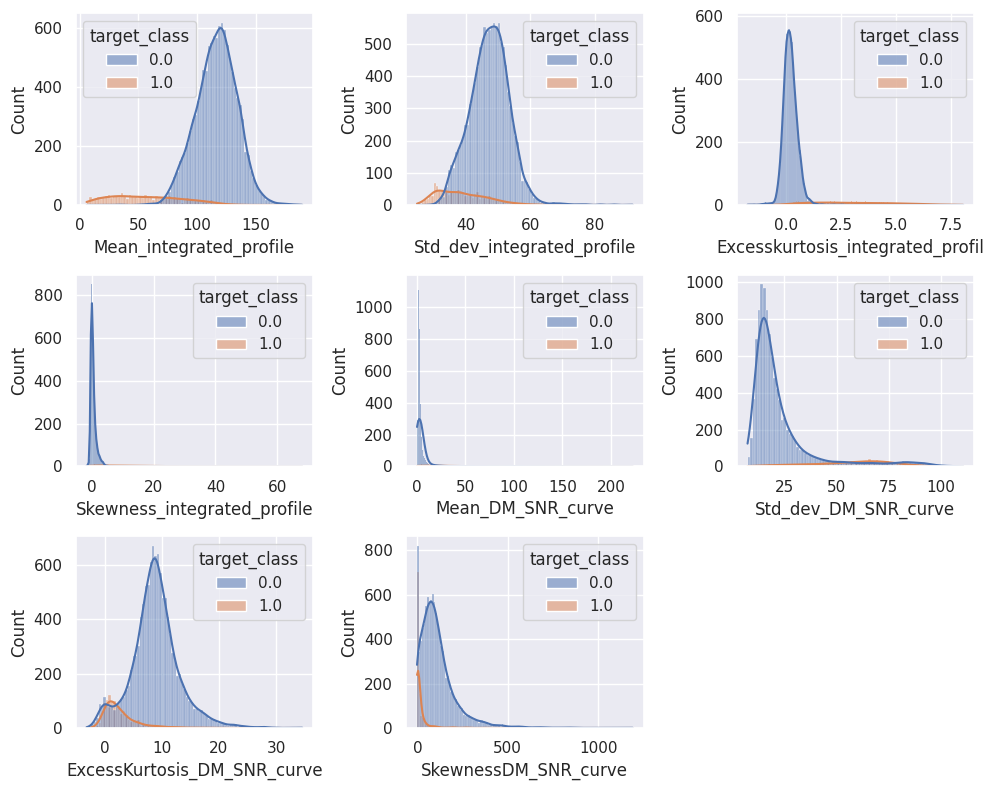

In [9]:
# 2.3 Lets look at the distribution plot of the features:
#     styles: https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html

sns.set_theme()
pos = 1
fig = plt.figure(figsize=(10,18));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=sns.histplot(data = data, x = i,ax=ax, hue = 'target_class', kde = 'True');
    plt.tight_layout();

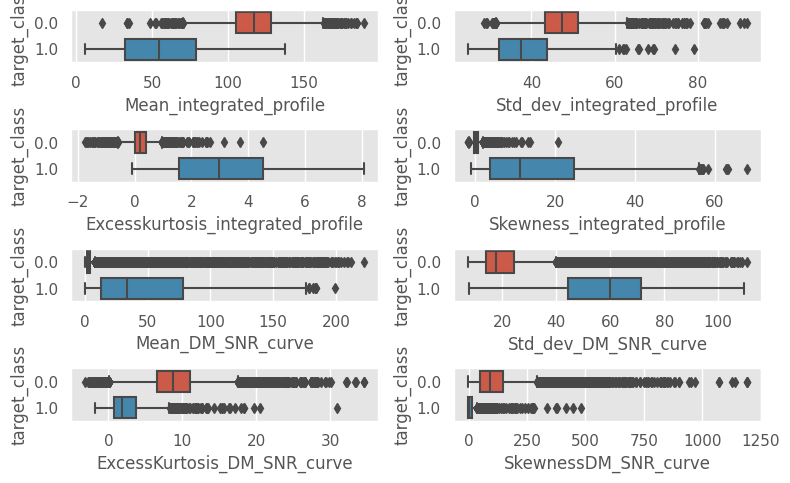

In [10]:
# 2.4 Lets look at how features are related to target:

plt.style.use("ggplot")
df = data.copy()
df['target_class'] = df['target_class'].astype("string")
plt.style.use("ggplot")
pos = 1
fig = plt.figure(figsize=(8,8));
for i in data.columns[:-1]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=sns.boxplot(data=df, x=i, y='target_class')
    plt.tight_layout();

del(df)

In [11]:
# 2.5 Pop out target and check
#       proportions of classes

y = data.pop("target_class")

# 2.0.2 Imbalanced data:
y.value_counts(normalize = True)

0.0    0.907966
1.0    0.092034
Name: target_class, dtype: float64

## Transform numeric data to categorical

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in `CatEncodersFamily` class.

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in `orig_train` and `train_binned` on the one hand and `orig_test` and `test_binned` on the other hand.

In [12]:
# 3.0 How many unique values exist per column?
#     So 30 bins per column should not be excessive:

for i in data.columns[:-1]:
  print(f"No of unique values in {i}:  \t {data[i].nunique()}")

No of unique values in Mean_integrated_profile:  	 7192
No of unique values in Std_dev_integrated_profile:  	 12510
No of unique values in Excesskurtosis_integrated_profile:  	 10793
No of unique values in Skewness_integrated_profile:  	 12528
No of unique values in Mean_DM_SNR_curve:  	 7224
No of unique values in Std_dev_DM_SNR_curve:  	 11348
No of unique values in ExcessKurtosis_DM_SNR_curve:  	 12526


In [13]:
# 3.0.1 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                                 y,
                                                                                 bins = 30,
                                                                                 test_size = 0.1,
                                                                                 genColName = False  # Keep orig col names
                                                                                )

In [14]:
# 3.0.2 Check  original data:

orig_train.shape   # (11276, 9)
orig_train.head(3)
orig_test.head(3)


(11276, 9)

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
225,78.460938,37.632246,0.761066,2.516426,2.241639,17.166000,8.768599,85.693532,0.0
9788,137.500000,37.165172,NaN,1.245371,3.239130,25.127128,8.179860,68.019792,0.0
408,104.585938,48.763704,1.217617,1.745403,43.056856,68.276894,1.392848,0.564216,0.0


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
2775,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
5,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
9484,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0


In [15]:
# 3.0.3 Check discretised features
#       train/test in binned data and original
#       split data have the same row-indicies:

train_binned.shape     # (11276, 9)
train_binned.head(3)
test_binned.head(3)


(11276, 9)

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
225,412,86,128,162,201,243,2810,323,0.0
9788,422,86,NaN,162,201,246,2810,322,0.0
408,417,811,1210,162,206,2418,284,321,0.0


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
2775,419,811,127,161,201,244,289,322,0.0
5,412,86,128,163,201,243,2810,323,0.0
9484,421,813,126,161,201,245,2810,322,0.0


In [16]:
# 3.0.4 No of unique values in train_binned
#       Less than 30 (no of bins) in a feature
#       would cause NaN values in test_binned
#       when transformed to numeric:

for i in train_binned.columns[:-1]:
  print(f"No of unique values in feature {i} are \t {train_binned[i].nunique()}")

No of unique values in feature Mean_integrated_profile are 	 30
No of unique values in feature Std_dev_integrated_profile are 	 28
No of unique values in feature Excesskurtosis_integrated_profile are 	 30
No of unique values in feature Skewness_integrated_profile are 	 29
No of unique values in feature Mean_DM_SNR_curve are 	 30
No of unique values in feature Std_dev_DM_SNR_curve are 	 30
No of unique values in feature ExcessKurtosis_DM_SNR_curve are 	 30
No of unique values in feature SkewnessDM_SNR_curve are 	 28


### Impute data: Learn using train data:

In [19]:
# 4.1 Impute original data
#     strategy: 'median'

si = SimpleImputer(strategy = 'median')
orig_train[:] = si.fit_transform(orig_train)
orig_test[:] = si.transform(orig_test)

In [20]:
# 4.2 Impute binned data:
#     strategy: 'most_frequent'

si = SimpleImputer(strategy = 'most_frequent')
train_binned[:] = si.fit_transform(train_binned)
test_binned[:] = si.transform(test_binned)

In [21]:
# 4.3 Pop out targets:

ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [22]:
## 5.0 Developing models
#      Decide our cat_cols

if 'target' not in train_binned.columns:
  cat_cols = list(train_binned.columns)  # All columns
  # Keep interacting columns, same
  # as cat columns:
  interactingCatCols = cat_cols  # alternative: []

len(cat_cols)  # 8



8

In [23]:
# 5.1 Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,0,0],  # This is better than all 1s
                       saveGraph = True
                       )

# Fit it:
ct.fit(train_binned, cat_cols, interactingCatCols)


Folder  /content/allmodels/models created to deposit cat encoder models and graph related files
Record set no is 1  
Set of records is:  [('Mean_integrated_profile', 'Std_dev_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Excesskurtosis_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Skewness_integrated_profile', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Mean_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Std_dev_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'ExcessKurtosis_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'SkewnessDM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Mean_integrated_profile_p_Mean_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Skewness_integrated_profile_p_Std_dev_DM_SNR_curve', [1, 1, 1, 1, None, 0, 0]), ('Mean_integrated_profile', 'Std_dev_integrated_profile_p_SkewnessDM

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 0, 0],
                  modelsPath=PosixPath('/content/allmodels/models'),
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'),
                  saveGraph=True)

## Data transformation

In [28]:
# 6.0 Transform both 'test_binned' and 'train_binned' data:
#     Takes time....

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 8.784032 MB
Mem usage after dtype transformation is: 4.437088 MB


'Transformed test data shape: (1252, 876)'

In [25]:
# 6.0.1 Transform train_binned now:
#       Takes time....

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1120
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 79.112416 MB
Mem usage after dtype transformation is: 39.962144 MB


'Transformed train data shape: (11276, 876)'

Our new features are substantially difft from original features. Prefixes to feature names imply as below:
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [26]:
# 6.1 Observe data now:
#     It also has original binned cols (10):

train_trans.head()
test_trans.head()

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,deg_Mean_integrated_profile_ck_Std_dev_integrated_profile,eig_Mean_integrated_profile_ck_Std_dev_integrated_profile,...,pr_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,deg_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,eig_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,pr_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,clu_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,deg_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,eig_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,pr_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve
0,412,86,128,162,201,243,2810,323,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.185185,0.147612,0.032445,0.800000
1,422,86,126,162,201,246,2810,322,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.111111,0.101621,0.021618,1.000000
2,417,811,1210,162,206,2418,284,321,1.0,0.185046,...,0.046330,0.740741,1.000000,0.202370,0.041998,0.866097,0.777778,0.481320,0.120603,0.233333
3,421,812,126,161,201,245,289,322,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.111111,0.101621,0.021618,1.000000
4,417,86,127,162,201,242,2811,324,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.222222,0.173638,0.037604,0.733333


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,deg_Mean_integrated_profile_ck_Std_dev_integrated_profile,eig_Mean_integrated_profile_ck_Std_dev_integrated_profile,...,pr_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Std_dev_DM_SNR_curve,deg_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,eig_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,pr_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,clu_SkewnessDM_SNR_curve_ck_Std_dev_integrated_profile_p_Skewness_integrated_profile,deg_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,eig_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,pr_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve,clu_SkewnessDM_SNR_curve_ck_Skewness_integrated_profile_p_ExcessKurtosis_DM_SNR_curve
0,419,811,127,161,201,244,289,322,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.111111,0.101621,0.021618,1.000000
1,412,86,128,163,201,243,2810,323,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.185185,0.147612,0.032445,0.800000
2,421,813,126,161,201,245,2810,322,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.111111,0.101621,0.021618,1.000000
3,425,811,125,161,203,243,285,321,1.0,0.185046,...,0.046330,0.740741,1.000000,0.202370,0.041998,0.866097,0.777778,0.481320,0.120603,0.233333
4,413,86,128,163,201,244,2810,322,1.0,0.185046,...,0.033315,0.941520,0.962963,0.201738,0.038653,0.932308,0.111111,0.101621,0.021618,1.000000


## Make an archive of files in gdrive
This is for later use


In [29]:
# 6.2 Mount google drive:

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### Archive of graph files to gdrive

In [30]:
# 6.2.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [31]:
# 6.3 Archive folder where graph files are stored to gdrive
output_filename = outputfolder / "models"
dir_to_be_archived = "/content/allmodels/models/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )


# 6.3.2 Unpack the zipped file at gdrive now:
shutil.unpack_archive(str(output_filename) +".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/allmodels/models.zip'

In [32]:
# 6.4 Let us have a look at our list of (graph) stored files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/allmodels/models').glob('**/*')
files = [x for x in p if x.is_file()]
files[:3]

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/Skewness_integrated_profile_projected_ExcessKurtosis_DM_SNR_curve_p_SkewnessDM_SNR_curve.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/SkewnessDM_SNR_curve_projected_Excesskurtosis_integrated_profile_p_SkewnessDM_SNR_curve.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/Excesskurtosis_integrated_profile_projected_Excesskurtosis_integrated_profile_p_Std_dev_DM_SNR_curve.gml')]

### Archive of datafiles

In [33]:
# 6.5  Let us also copy our original and binned
#      files to a local folder
#       We will later copy them to gfrive:


train_binned['target'] = ytr
test_binned['target'] = yte

destination = Path("/content/datafiles/data/")
destination.mkdir(parents=True, exist_ok=True)

trfile = destination / "train_binned.pkl"
tefile = destination / "test_binned.pkl"
ortrfile = destination / "orig_train.pkl"
ortefile = destination / "orig_test.pkl"

train_binned.to_pickle(trfile)
test_binned.to_pickle(tefile)
orig_train.to_pickle(ortrfile)
orig_test.to_pickle(ortefile)

In [34]:
# 6.5.1 Delete if a folder already exists on gdrive:
outputfolder = Path("/gdrive/MyDrive/Colab_data_files/datafiles/")
if outputfolder.exists() and outputfolder.is_dir():
    shutil.rmtree(outputfolder)  # Delete if it exists

In [35]:
# 6.5.2 Archive folder where pickle files are stored to gdrive
output_filename = outputfolder / "data"
dir_to_be_archived = "/content/datafiles/data/"
shutil.make_archive(output_filename, 'zip', dir_to_be_archived )



# 6.6 Unpack the zipped file now:
shutil.unpack_archive(str(output_filename)+".zip", output_filename, 'zip')

'/gdrive/MyDrive/Colab_data_files/datafiles/data.zip'

In [36]:
# 6.7 Let us have a look at our list of pickled files:
p = Path(r'/gdrive/MyDrive/Colab_data_files/datafiles/data').glob('**/*')
files = [x for x in p if x.is_file()]
files

[PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_train.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/train_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/test_binned.pkl'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_test.pkl')]

In [ ]:
# 6.8 Pop out target:
#     It is already popped out

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCAs with original data and with transformed data:
We perform PCA of transformed data with all features. We latter perform PCA again but only with important features.

In [38]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(11276, 2)

In [39]:
# 7.1 PCA with transformed train data.
#     Drop all cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]   # Drop the six binned columns
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape  # (18000, 2)

(11276, 2)

In [40]:
# 7.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

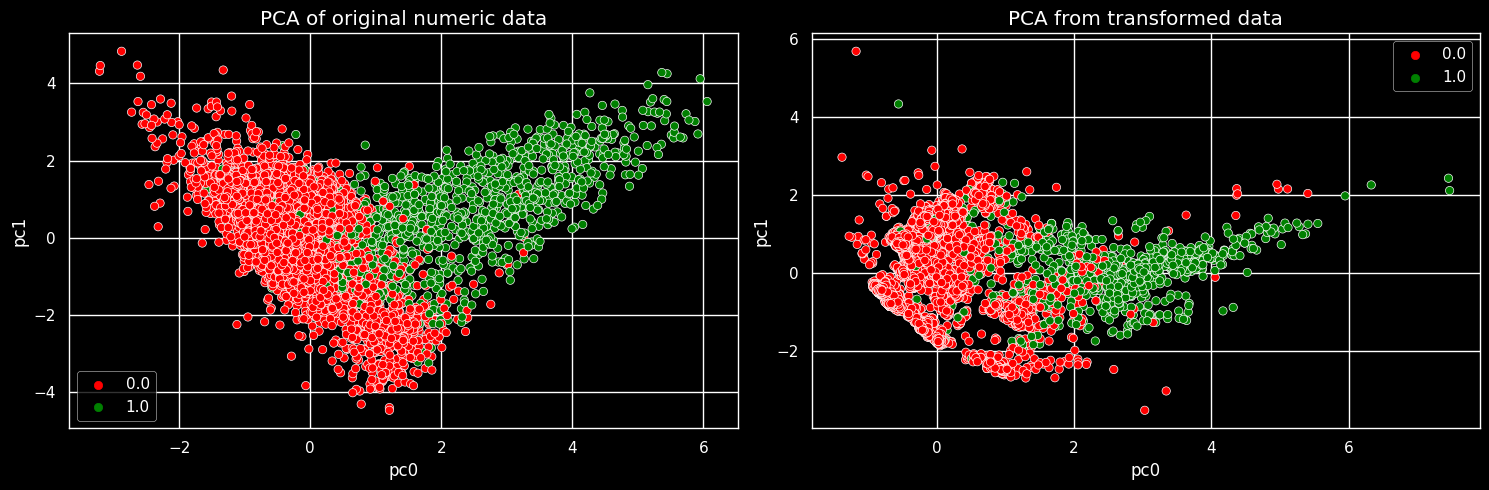

In [42]:
# 8.1 2D PCA plot from original train data:
fig = plt.figure(figsize = (15,5));
fig.add_subplot(1,2,1);
plt.style.use("dark_background");
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA of original numeric data');

# 8.2 2D PCA plot from transformed train data:

fig.add_subplot(1,2,2);
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed data') ;

plt.tight_layout();




##xgboost modeling of original features and of transformed features


In [43]:
# 9.0 Original train/test data:

model_orig = xgb.XGBClassifier( n_estimators= 700,
                               verbosity = 3,
                               eta = 0.06,
                               max_depth = 6,
                               subsample = 0.8,
                               random_state = None,
                              )

# 9.0.1
tr_X =   orig_train
test_X = orig_test
ytr = ytr
yte = yte

# 9.0.2
model_orig.fit(tr_X, ytr.values,
               early_stopping_rounds = 100,
               eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
               eval_metric = ['auc']
              )



[14:54:54] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:54:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.95023	validation_1-auc:0.94589
[14:54:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.97006	validation_1-auc:0.96251
[14:54:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.96945	validation_1-auc:0.96002
[14:54:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.96979	validation_1-auc:0.95983
[14:54:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.96904	validation_1-auc:0.95925
[14:54:54] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 42 extra nodes, 0 pruned nodes, max_d

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=700, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

In [44]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9752221339305064'

'Best iteration from orig train/test data: 216'

In [45]:
# 9.2 Modeling with transformed train/test data:

model_trans = xgb.XGBClassifier( n_estimators= 600,
                                  verbosity = 3,
                                  eta = 0.06,
                                  max_depth = 14,
                                  subsample = 0.8,
                                  random_state = None,
                           )

# 9.21
tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr
yte = yte

# 9.22
model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 100,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[14:55:28] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:55:29] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=11
[0]	validation_0-auc:0.95147	validation_1-auc:0.94369
[14:55:30] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation_0-auc:0.96595	validation_1-auc:0.94291
[14:55:31] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.97298	validation_1-auc:0.95572
[14:55:31] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=9
[3]	validation_0-auc:0.97157	validation_1-auc:0.95514
[14:55:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=12
[4]	validation_0-auc:0.97493	validation_1-auc:0.95917
[14:55:32] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes,

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

### Learning curve plots

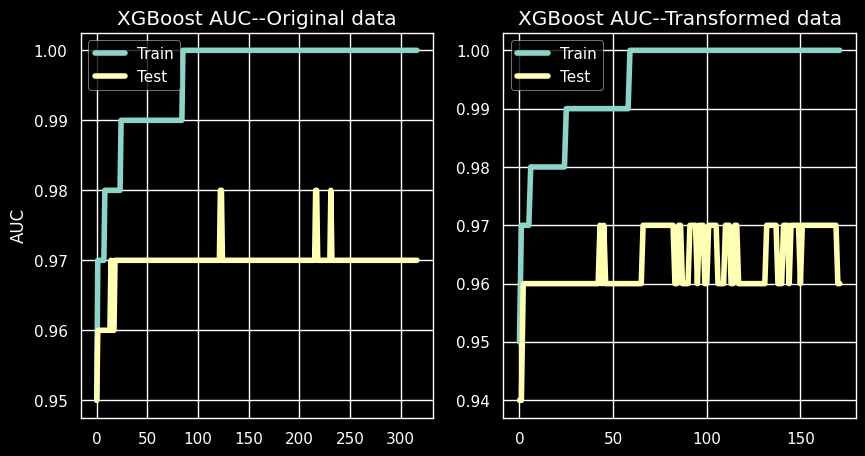

In [46]:
# 9.3 Modeling with original data:

# Ref: https://stackoverflow.com/a/60366515
fig, ax = plt.subplots(1,2, figsize = (10,5));

results = model_orig.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[0].plot(x_axis, np.round(results['validation_0']['auc'],2),linewidth=4, label='Train');
ax[0].plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth=4, label='Test');
ax[0].legend();
ax[0].set_ylabel('AUC');
ax[0].set_title("XGBoost AUC--Original data")

# 9.4 Modeling with transformed data:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0,epochs)
ax[1].plot(x_axis, np.round(results['validation_0']['auc'],2), linewidth=4, label='Train');
ax[1].plot(x_axis, np.round(results['validation_1']['auc'],2), linewidth = 4, label='Test');
ax[1].legend();
ax[1].set_title('XGBoost AUC--Transformed data');
plt.show();

In [47]:
# 9.5
f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9665815855586859'

'Best iteration from transformed train/test data: 71'

## Feature importance of transformed features:
Extract feature importance using function `utils.xgImptFeatures()`. The function outputs three objects as follows::
>`fe_1`: List of columns arranged in order of descending xgboost impt(feat-impt >0)<br>
>`fe_0`: List of columns whose xgboost importance is zero<br>
>`fe`: One-column dataframe of feature importance(top-down). Col name is 'imp'<br>

In [48]:
# 10.0 Get feature importance:

fe_1, fe_0, fe = utils.xgImptFeatures(model_trans,  train_trans.iloc[:,len(cat_cols):].columns)
print("\n=== DataFrame  of impt features top-down =======\n")
fe.iloc[:5]
print("\n\n== Column-list whose feat impt >0 =======\n")
fe_1[:5]     # Arranged in descending order of impt
print("\n\n===Column-list whose feat impt is 0 =======\n")
fe_0[:5]


Order of feature importance is by 'gain'

=== DataFrame  of impt features top-down =======



,imp
clu_Skewness_integrated_profile_ck_Std_dev_integrated_profile_p_Mean_DM_SNR_curve,0.308100
eig_Skewness_integrated_profile_ck_Mean_integrated_profile_p_Std_dev_integrated_profile,0.258577
pr_Excesskurtosis_integrated_profile_ck_Mean_DM_SNR_curve_p_Std_dev_DM_SNR_curve,0.027768
clu_Excesskurtosis_integrated_profile_ck_Mean_integrated_profile_p_Std_dev_integrated_profile,0.008747
deg_Excesskurtosis_integrated_profile_ck_Mean_DM_SNR_curve_p_Std_dev_DM_SNR_curve,0.008271




== Column-list whose feat impt >0 =======



['clu_Skewness_integrated_profile_ck_Std_dev_integrated_profile_p_Mean_DM_SNR_curve',
 'eig_Skewness_integrated_profile_ck_Mean_integrated_profile_p_Std_dev_integrated_profile',
 'pr_Excesskurtosis_integrated_profile_ck_Mean_DM_SNR_curve_p_Std_dev_DM_SNR_curve',
 'clu_Excesskurtosis_integrated_profile_ck_Mean_integrated_profile_p_Std_dev_integrated_profile',
 'deg_Excesskurtosis_integrated_profile_ck_Mean_DM_SNR_curve_p_Std_dev_DM_SNR_curve']



===Column-list whose feat impt is 0 =======



['pr_Std_dev_integrated_profile_ck_ExcessKurtosis_DM_SNR_curve_p_SkewnessDM_SNR_curve',
 'eig_ExcessKurtosis_DM_SNR_curve_ck_Excesskurtosis_integrated_profile_p_Mean_DM_SNR_curve',
 'eig_SkewnessDM_SNR_curve_ck_Mean_integrated_profile_p_Std_dev_integrated_profile',
 'pr_ExcessKurtosis_DM_SNR_curve_ck_Excesskurtosis_integrated_profile_p_Mean_DM_SNR_curve',
 'clu_Mean_integrated_profile_ck_Std_dev_integrated_profile_p_SkewnessDM_SNR_curve']

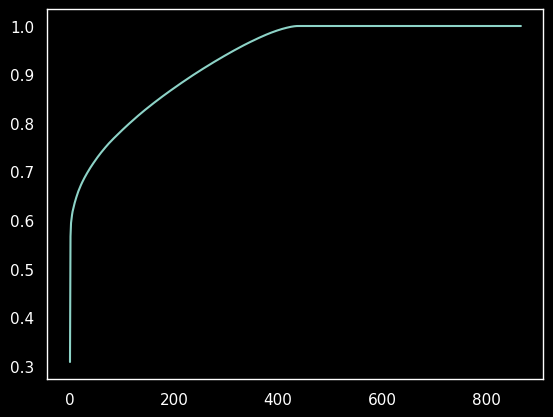

In [49]:
# 10.1 Cumulative sum of feature importance.
#      Last 100 columns have zero or (near zero)
#      importance:

plt.plot(range(len(fe)), fe['imp'].cumsum().values);
plt.grid();

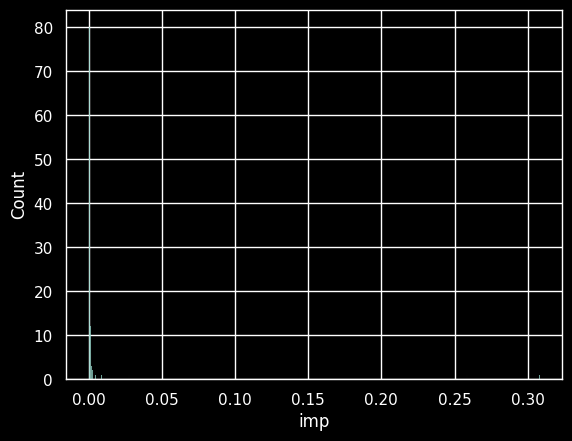

In [50]:
# 10.2 A histogram plot of feature importance score
#      Most columns have feature impt much below 0.01

sns.histplot(fe['imp'][fe_1]);

### XGBoost modeling with impt features

In [51]:
# 11.0 Modeling of transformed train/test data with impt features:

model_trans = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,
                           max_depth = 14,
                           subsample = 0.8,
                           random_state = None,
                           )

# 11.0.1
tr_X =   train_trans[fe_1[:30]]
test_X = test_trans[fe_1[:30]]
ytr = ytr
yte = yte


# 11.0.2
model_trans.fit(tr_X, ytr.values,
          early_stopping_rounds = 50,
          eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
          eval_metric = ['auc']
          )



[14:58:59] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[14:58:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=10
[0]	validation_0-auc:0.95125	validation_1-auc:0.94436
[14:58:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=11
[1]	validation_0-auc:0.96667	validation_1-auc:0.95744
[14:58:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 80 extra nodes, 0 pruned nodes, max_depth=10
[2]	validation_0-auc:0.97096	validation_1-auc:0.95571
[14:58:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[3]	validation_0-auc:0.97107	validation_1-auc:0.95577
[14:58:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=11
[4]	validation_0-auc:0.97341	validation_1-auc:0.96088
[14:58:59] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 90 extra nodes, 0 pruned nodes, 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, predictor=None, ...)

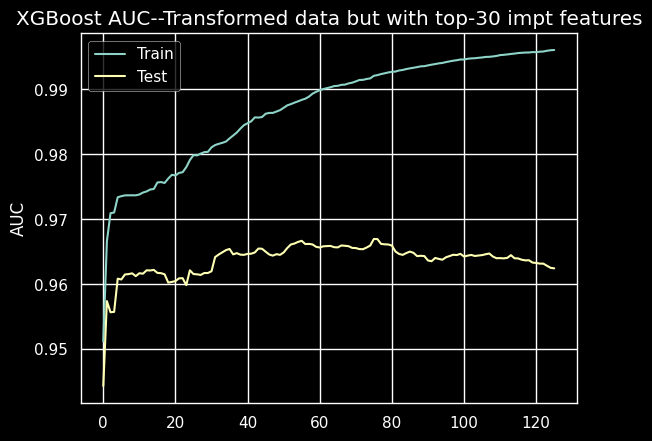

In [52]:
# 11.1 Learning curve: Modeling with transformed data:
#      We get results better than with all features:

results = model_trans.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)
fig, ax = plt.subplots();
ax.plot(x_axis, results['validation_0']['auc'], label='Train');
ax.plot(x_axis, results['validation_1']['auc'], label='Test');
ax.legend();
plt.ylabel('AUC');
plt.title('XGBoost AUC--Transformed data but with top-30 impt features');
plt.show();

## PCAs with original data and impt features of transformed data:
While performing PCA, we only use impt features

In [53]:
# 12.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

(11276, 2)

In [64]:
# 12.1 PCA with transformed train data.
#      We keep just the impt features

trans_pca = train_trans[fe_1[:40]] #.iloc[:,len(cat_cols):]
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

(11276, 2)

In [65]:
# 12.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

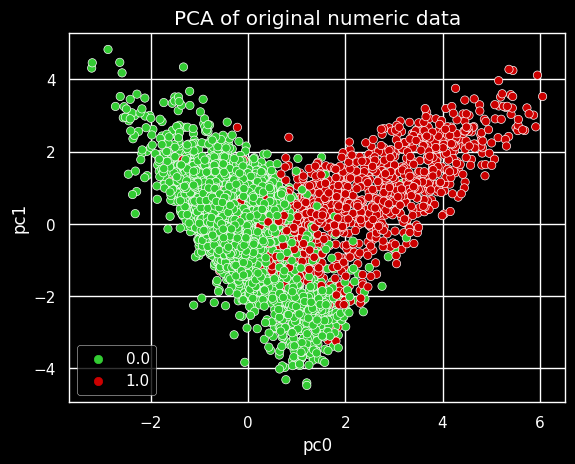

In [56]:
# 12.3 PCA plot from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


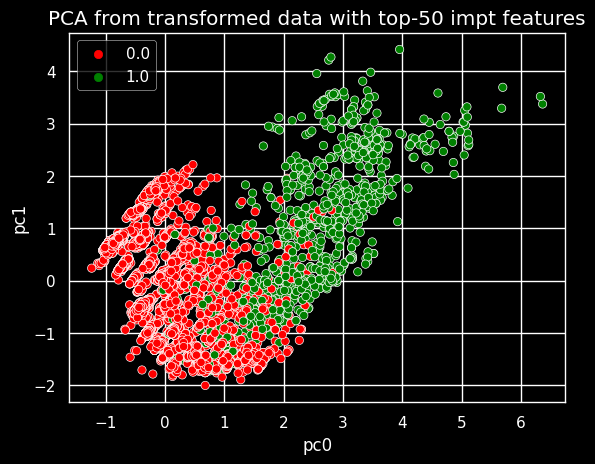

In [66]:
# 12.4 PCA plot from transformed data but with impt features:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green"]
                ).set(title='PCA from transformed data with top-50 impt features') ;


## Correlation with orig columns
Correlation of extracted features with original features

In [67]:
# 13.0 Take top five imp features:

tt = train_trans[fe_1[:10]].copy()
tt.shape  # (9000,341)

(11276, 10)

In [68]:
# 13.1 Reindex orig_train and merge with 'tt':

ot= orig_train.reset_index(drop = True).copy()
result = ot.merge(tt, left_index = True, right_index=True )


Correlation heatmap shows good amount of correlation between the two sets of features

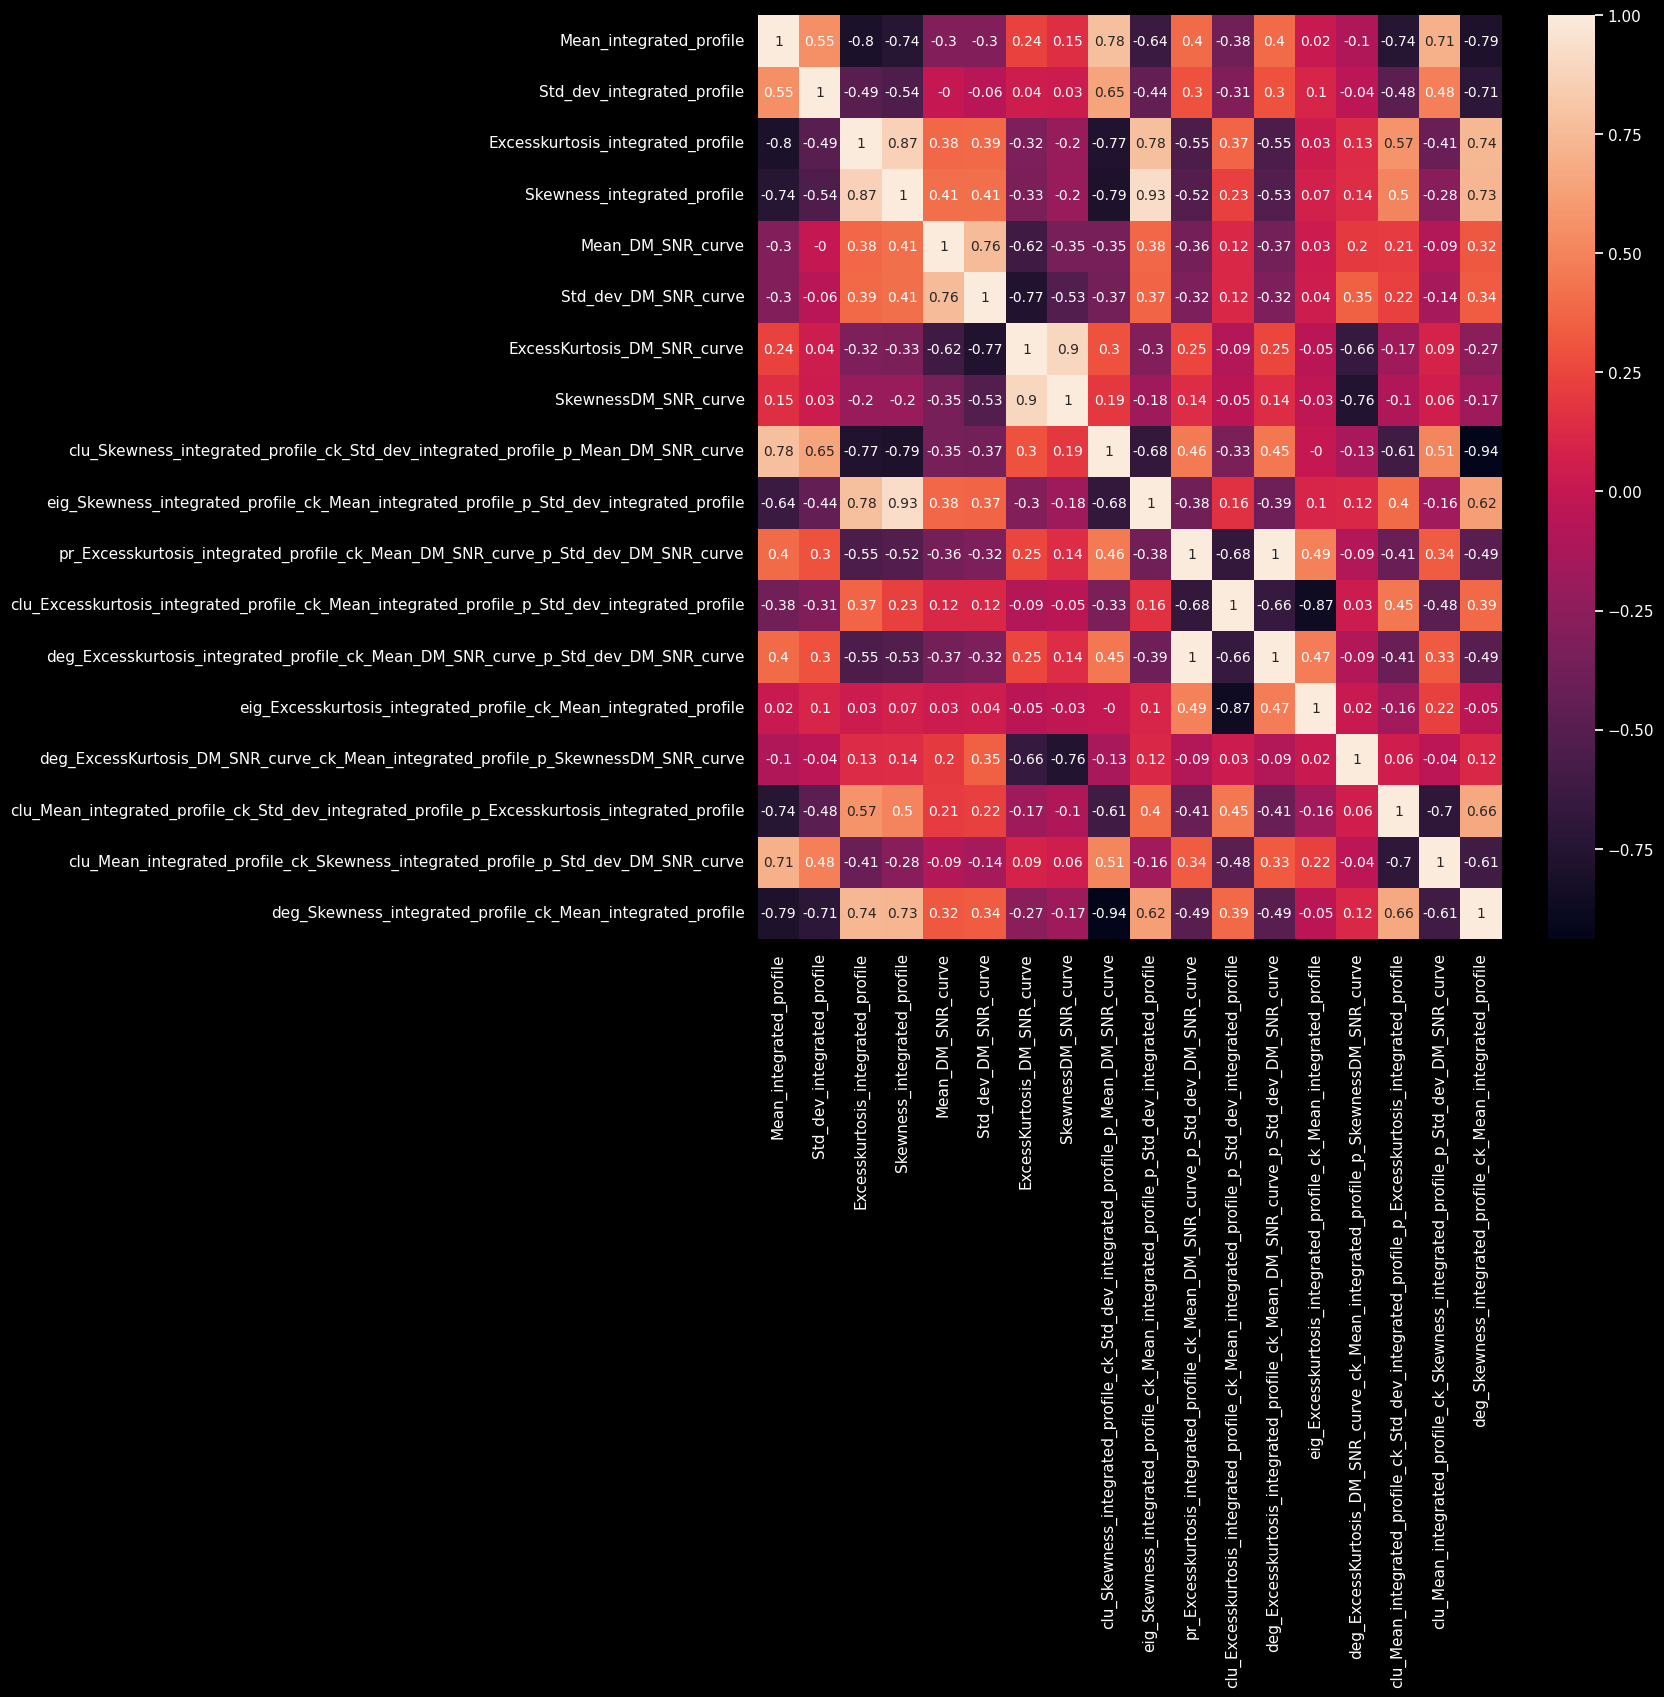

In [70]:
# 13.2 Correlation heatmap:

plt.figure(figsize = (12,12))
sns.heatmap(np.round(result.corr(),2), annot = True);

## Distribution of columns
Distribution of columns related to different centrality measures

### Proportion of columns by centrality measure:

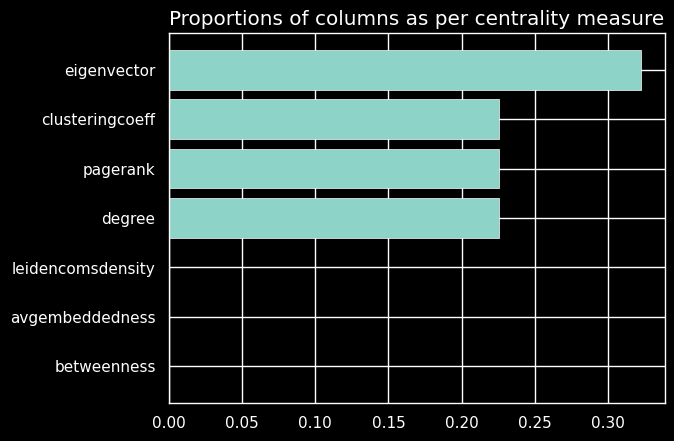

In [71]:
# 14.0 Our list of columns

colList = (train_trans.iloc[:,len(cat_cols):]).columns

# Count of columns by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(colList, normalize = True)
utils.plotSeries(f, "Proportions of columns as per centrality measure")

### Proportions of columns by centrality whose impt is > 0

In [72]:
# 14.1 Extract column importance:

fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
print("\n")
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 29'

'Columns whose impt is 0: 1'

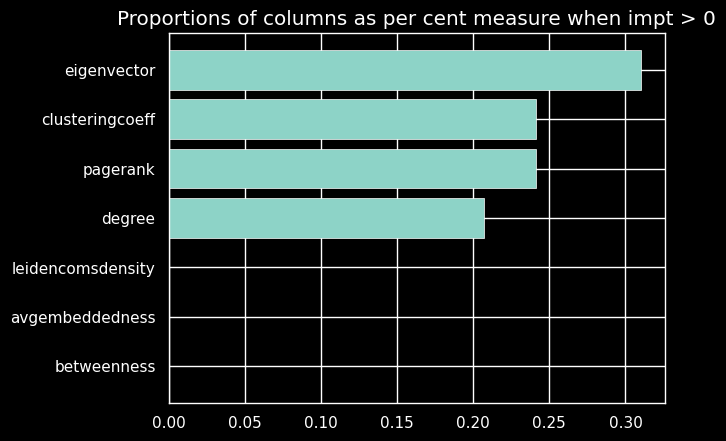

In [73]:
# 14.2 Count of columns whose xgboost impt > 0 by centrality measure and its plot:
f = utils.featureImptByCentFeatCounts(fe_1, normalize = True)
utils.plotSeries(f, "Proportions of columns as per cent measure when impt > 0")

### Proportions of columns by summed-up importance score of each centrality measure

In [74]:
# 15.0 Extract xgboost feature importance:
fe_1, _, fe = utils.xgImptFeatures(model_trans, colList)



Order of feature importance is by 'gain'


In [75]:
# 15.1 Column-wise importance score (whose impt > 0)
#      score is a Pandas Series
score = fe['imp'][fe_1]

# 15.2 Score of all impt columns:
score[:5]

eig_Mean_integrated_profile_ck_Std_dev_integrated_profile           0.551072
deg_Mean_integrated_profile_ck_Std_dev_integrated_profile           0.122998
pr_Mean_integrated_profile_ck_Std_dev_integrated_profile            0.032272
eig_Mean_integrated_profile_ck_Excesskurtosis_integrated_profile    0.029913
eig_Mean_integrated_profile_ck_Skewness_integrated_profile          0.021559
Name: imp, dtype: float32

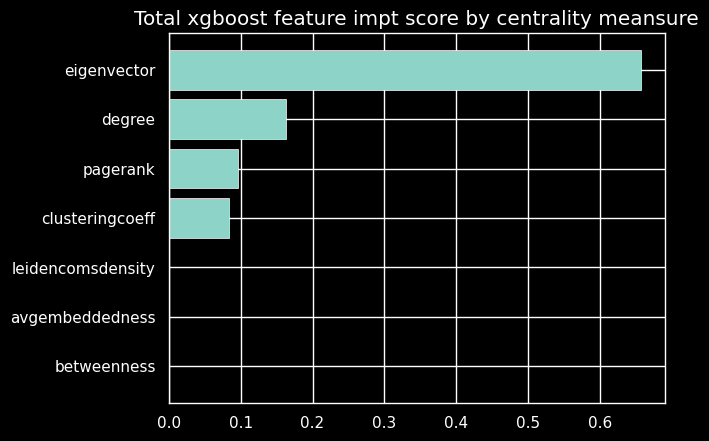

In [76]:
# 15.3 Extract and plot total xgboost impt scores by centrality measure:

g = utils.featureImptByScore(score, fe_1, True)
utils.plotSeries(g, "Total xgboost feature impt score by centrality meansure")

## Analysing Graphs

### Read graph files from gdrive

In [77]:
# 15.0 Mount gdrive:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [78]:
# 15.1 Path where .gml files are placed:

pathToFolder = Path("/gdrive/MyDrive/Colab_data_files/allmodels/models")
filelist = sorted(list(pathToFolder.iterdir()))
filelist[:5]   # a_bigraph_*

[PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExcessKurtosis_DM_SNR_curve_bigraph_ExcessKurtosis_DM_SNR_curve_p_SkewnessDM_SNR_curve.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExcessKurtosis_DM_SNR_curve_bigraph_Excesskurtosis_integrated_profile.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExcessKurtosis_DM_SNR_curve_bigraph_Excesskurtosis_integrated_profile_p_ExcessKurtosis_DM_SNR_curve.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExcessKurtosis_DM_SNR_curve_bigraph_Excesskurtosis_integrated_profile_p_Mean_DM_SNR_curve.gml'),
 PosixPath('/gdrive/MyDrive/Colab_data_files/allmodels/models/ExcessKurtosis_DM_SNR_curve_bigraph_Excesskurtosis_integrated_profile_p_SkewnessDM_SNR_curve.gml')]

### Read data files from gdrive:

In [79]:
# 16.0
orig_test = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_test.pkl")
orig_train = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/orig_train.pkl")
train_binned = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/train_binned.pkl")
test_binned = pd.read_pickle("/gdrive/MyDrive/Colab_data_files/datafiles/data/test_binned.pkl")

In [80]:
# 16.1 check data files:
#      All have 'target' col
orig_train.head(2)
orig_test.head(2)
train_binned.head(2)
test_binned.head(2)

,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve
225,78.460938,37.632246,0.761066,2.516426,2.241639,17.166000,8.768599,85.693532
9788,137.500000,37.165172,0.224732,1.245371,3.239130,25.127128,8.179860,68.019792


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve
2775,121.15625,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298
5,76.96875,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
225,412,86,128,162,201,243,2810,323,0.0
9788,422,86,126,162,201,246,2810,322,0.0


,Mean_integrated_profile,Std_dev_integrated_profile,Excesskurtosis_integrated_profile,Skewness_integrated_profile,Mean_DM_SNR_curve,Std_dev_DM_SNR_curve,ExcessKurtosis_DM_SNR_curve,SkewnessDM_SNR_curve,target
2775,419,811,127,161,201,244,289,322,0.0
5,412,86,128,163,201,243,2810,323,0.0


### Display graphs

In [82]:
# 17.0 Get sample list of projected and bigraphs:

projected = [str(i).split("/")[-1] for i in filelist if 'Mean_integrated_profile_projected' in str(i)]

bigraph = [str(i).split("/")[-1] for i in filelist if 'Mean_integrated_profile_bigraph' in str(i)]
sb = sorted(bigraph, key=len)
sb[:5]   # bigraph files
print("\n\n====\n")
sp = sorted(projected, key=len)
sp[:5]    # projected graph files

['Mean_integrated_profile_bigraph_Mean_DM_SNR_curve.gml',
 'Mean_integrated_profile_bigraph_SkewnessDM_SNR_curve.gml',
 'Mean_integrated_profile_bigraph_Std_dev_DM_SNR_curve.gml',
 'Mean_integrated_profile_bigraph_Std_dev_integrated_profile.gml',
 'Mean_integrated_profile_bigraph_ExcessKurtosis_DM_SNR_curve.gml']



====



['Mean_integrated_profile_projected_Mean_DM_SNR_curve.gml',
 'Mean_integrated_profile_projected_SkewnessDM_SNR_curve.gml',
 'Mean_integrated_profile_projected_Std_dev_DM_SNR_curve.gml',
 'Mean_integrated_profile_projected_Std_dev_integrated_profile.gml',
 'Mean_integrated_profile_projected_ExcessKurtosis_DM_SNR_curve.gml']

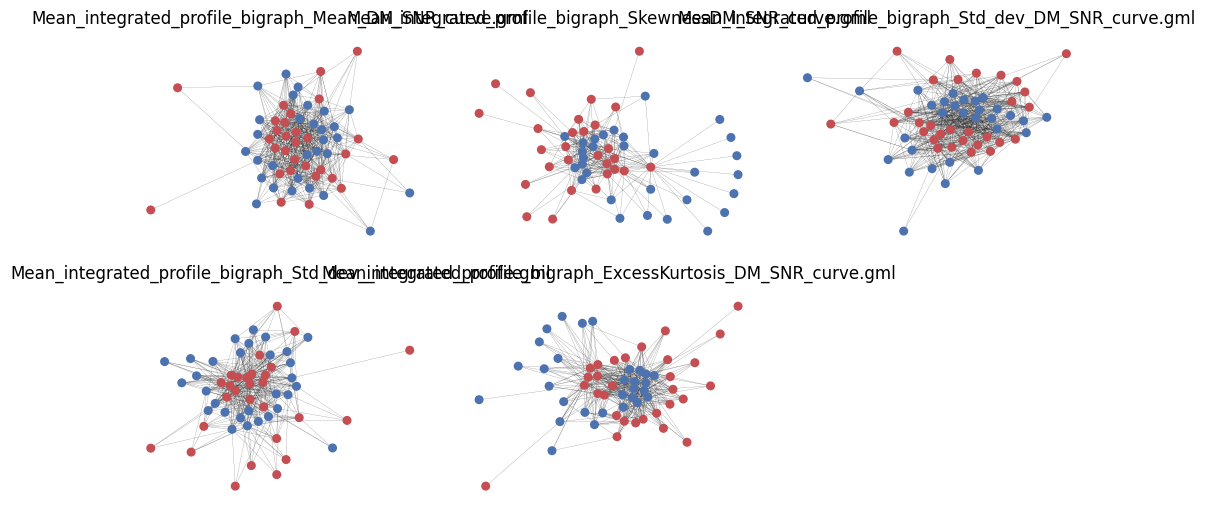

In [83]:
# 17.1 Plot of sample bigraphs:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(10,18));
for i in sb[:5]:
    ax = fig.add_subplot(7,3,pos);
    pos = pos + 1
    _=utils.plotBipartiteGraph(i,pathToFolder, ax = ax, title = i, connected = True);
    plt.tight_layout();

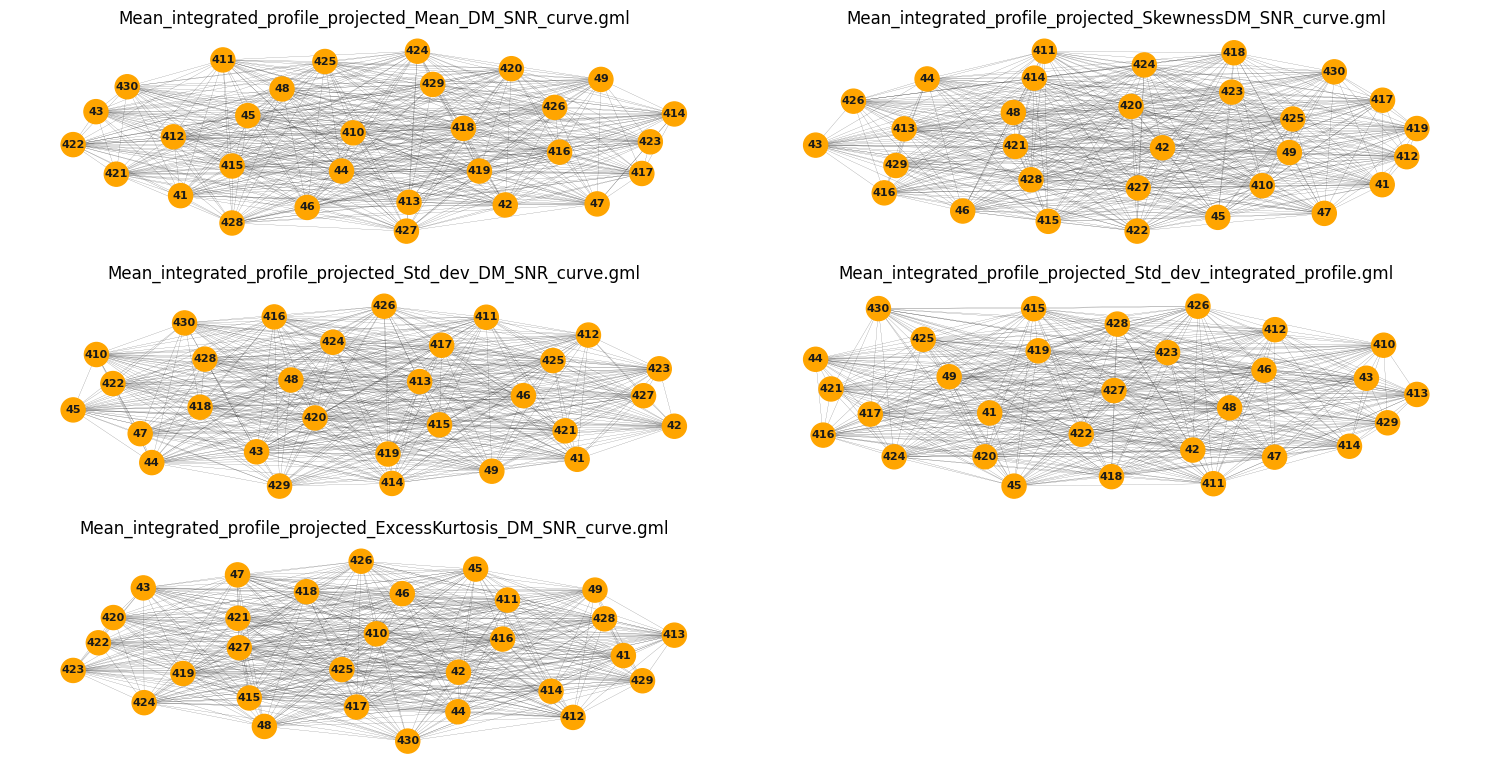

In [84]:
# 17.2 Plot of sample projected graph files
#      And community visualization within them
#      Modularity class is used to distinguish
#      communities:

plt.style.use('default')
pos = 1
fig = plt.figure(figsize=(15,18));
for i in sp[:5]:
    ax = fig.add_subplot(7,2,pos);
    pos = pos + 1
    _=utils.communityVisualization(i,pathToFolder, ax = ax, withLabels = True, title = i);
    plt.tight_layout();

## Transform binned data to communities:

In [86]:
# 18.0 Transform each column bin as per the community
#       to which it belongs:

# 18.1 Binnedd cols are:
columnNames = cat_cols

# 18.2 Communities will be created as per this algo:
algolist = [nx.community.greedy_modularity_communities]

# 18.3 Graph files are within:
pathToGraphFolder= "/gdrive/MyDrive/Colab_data_files/allmodels/models"

# 18.4 Perform transformation of both train_binned and test_binend:
# 18.4.1 List of transformed datframes as per difft algo used
fg_tr = []
fg_te = []

# 18.4.2 PErform transformation to community structure
for algo in algolist:
  _,df_tr = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,train_binned,algo)
  _,df_te = utils.transformBinnedDF2Communities(columnNames,pathToGraphFolder,test_binned,algo)
  fg_tr.append(df_tr)
  fg_te.append(df_te)

KeyError: ignored

In [ ]:
# 18.5 Observe few rows of transformed data:
fg_tr[0].head(5)
fg_te[0].head(5)

,a_projected_b.gml,a_projected_c.gml,a_projected_d.gml,a_projected_e.gml,a_projected_f.gml,b_projected_a.gml,b_projected_c.gml,b_projected_d.gml,b_projected_e.gml,b_projected_f.gml,...,e_projected_a.gml,e_projected_b.gml,e_projected_c.gml,e_projected_d.gml,e_projected_f.gml,f_projected_a.gml,f_projected_b.gml,f_projected_c.gml,f_projected_d.gml,f_projected_e.gml
5945,1,0,0,0,1,1.0,1.0,1.0,0.0,0.0,...,1,0,1,1,0,1.0,0.0,1.0,1.0,0.0
3542,1,0,0,0,1,1.0,1.0,1.0,0.0,0.0,...,1,1,0,0,1,1.0,0.0,0.0,0.0,0.0
7625,0,0,0,0,0,1.0,1.0,1.0,0.0,0.0,...,0,0,1,1,0,0.0,0.0,1.0,1.0,0.0
8430,1,0,0,0,1,1.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1.0,0.0,1.0,1.0,0.0
2193,1,0,0,0,1,1.0,1.0,1.0,0.0,0.0,...,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0


,a_projected_b.gml,a_projected_c.gml,a_projected_d.gml,a_projected_e.gml,a_projected_f.gml,b_projected_a.gml,b_projected_c.gml,b_projected_d.gml,b_projected_e.gml,b_projected_f.gml,...,e_projected_a.gml,e_projected_b.gml,e_projected_c.gml,e_projected_d.gml,e_projected_f.gml,f_projected_a.gml,f_projected_b.gml,f_projected_c.gml,f_projected_d.gml,f_projected_e.gml
3187,0,0,0,1,0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,0,1,0.0,1.0,0.0,0.0,1.0
7123,0,0,0,1,0,0.0,0.0,0.0,1.0,1.0,...,1,1,0,0,1,0.0,1.0,0.0,0.0,1.0
9495,0,0,0,1,0,1.0,1.0,1.0,0.0,0.0,...,0,0,1,1,0,1.0,0.0,1.0,1.0,0.0
2945,0,0,0,1,0,0.0,1.0,1.0,0.0,0.0,...,0,0,1,1,0,1.0,0.0,1.0,1.0,0.0
4087,0,0,0,1,0,0.0,0.0,0.0,1.0,1.0,...,0,1,0,0,1,0.0,1.0,0.0,0.0,1.0


In [ ]:
# 18.6 Extract target columns:

ytr = train_binned['target']
yte = test_binned['target']

### xgboost modeling of transformed data:

In [ ]:
# 19.0 Modeling with transformed train/test data with impt features:

# Lest we repeat the process many times:
# Del the earlier result:

if 'model_trans_commu' in globals():
    del model_trans_commu

model_trans_commu = xgb.XGBClassifier(  n_estimators= 50,
                                        verbosity = 3,
                                        eta = 0.06,
                                        max_depth = 14,
                                        subsample = 0.8,
                                        random_state = None,
                                      )


tr_X =   fg_tr[0]
test_X = fg_te[0]
ytr = ytr
yte = yte


model_trans_commu.fit(tr_X, ytr.values,
                      early_stopping_rounds = 5,
                      eval_set=[ (tr_X, ytr.values), (test_X, yte.values)],
                      eval_metric = ['auc']
                      )



[13:10:12] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	validation_0-auc:1.00000	validation_1-auc:1.00000
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 8 extra nodes, 0 pruned nodes, max_depth=3
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[1]	validation_0-auc:1.00000	validation_1-auc:1.00000
[13:10:12] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 2 extra nodes, 0 pruned nodes, max_depth=1
[13:10:13] INFO: ../src/tree/updater_prune.cc:98: 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=14,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### PCA of transformed data:

In [ ]:
# 20.0 Impute train data:
from sklearn.impute import SimpleImputer
si = SimpleImputer(strategy = "most_frequent")
fg_tr[0][:] = si.fit_transform(fg_tr[0])
fg_tr[0].head(3)

,a_projected_b.gml,a_projected_c.gml,a_projected_d.gml,a_projected_e.gml,a_projected_f.gml,b_projected_a.gml,b_projected_c.gml,b_projected_d.gml,b_projected_e.gml,b_projected_f.gml,...,e_projected_a.gml,e_projected_b.gml,e_projected_c.gml,e_projected_d.gml,e_projected_f.gml,f_projected_a.gml,f_projected_b.gml,f_projected_c.gml,f_projected_d.gml,f_projected_e.gml
5945,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3542,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
7625,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


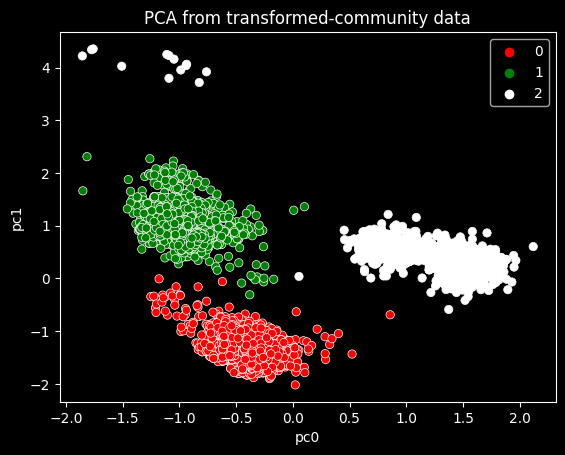

In [ ]:
# 20.1 PCA next:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
commu_pca = pca.fit_transform(ss.fit_transform(fg_tr[0]))
commu_pca.shape

# 20.2 Assign column names and transform to DataFrame;

colnames = ["pc" + str(i) for i in range(trans_pca.shape[1])]
commu_pca = pd.DataFrame(commu_pca, columns = colnames)

# 20.3 PCA plot of transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["red", "green", "white"]
                ).set(title='PCA from transformed-community data') ;